# Concensus clustering on Random Graphs

The graph obtained via UMAP has weights that can be interpreted as the probability of the edge’s existence. These weights can be used to generate several unweighted random graphs obtained by keeping edges with a probability proportional to their weights. We are exploring the idea of using a consensus clustering by clustering each random graph separately and see if this turns out to be a good way to obtain good clusters of the high dimensional points.

In [1]:
!git branch

  master
* pruning_graph


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

In [161]:
import leidenalg as la
import igraph as ig
from tqdm import tqdm

## Get data

In [142]:
dataset_id=1
raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)

k = get_dataset_params(dataset_id)['n_neighbors']

In [143]:
print(f'We are building a {k}-NN graph for dataset {dataset_name}')
A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                             n_neighbors=k, 
                                             random_state=0, 
                                             metric='euclidean', 
                                             return_dists=True,
                                             set_op_mix_ratio=1)


We are building a 5-NN graph for dataset coil


# Build ensemble members

We construct random graphs by flipping ( number_edges x ensemble_size) coins. Each flip determine if we keep a specific edge in a specific random graph.

In [144]:
ensemble_size = 20
number_edges = len(A_umap.data)
print(number_edges)

6596


In [157]:
coin_flips = np.random.rand(ensemble_size, number_edges)
keep_edges = coin_flips < A_umap.data
keep_edges.shape

(20, 6596)

Proportion of edges kept in each random graph

In [158]:
np.sum(keep_edges, axis=1)/number_edges

array([0.66479685, 0.65554882, 0.66115828, 0.65751971, 0.65782292,
       0.66130988, 0.66100667, 0.6573681 , 0.65964221, 0.65630685,
       0.66040024, 0.65979381, 0.65479078, 0.66691935, 0.65494239,
       0.65342632, 0.6531231 , 0.66146149, 0.65979381, 0.65918739])

Number of times edges are part of the random graphs

<AxesSubplot:ylabel='Count'>

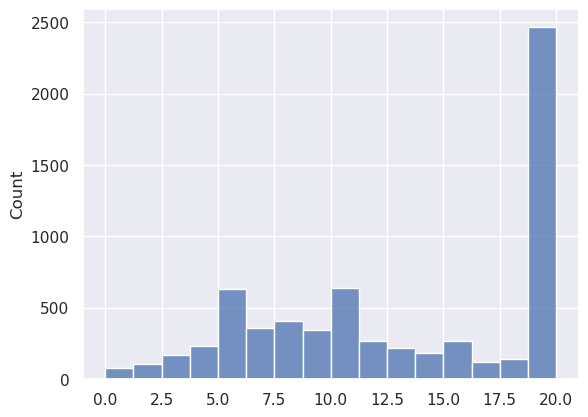

In [159]:
sns.histplot(np.sum(keep_edges, axis=0))

# Cluster the random graphs

In [162]:
clusters = dict()
for i in tqdm(range(ensemble_size)):
    A = A_umap.copy()
    A.data = keep_edges[i]
    G = ig.Graph.Adjacency(A)
    clusters[i] = la.find_partition(G, la.ModularityVertexPartition).membership

100%|██████████| 20/20 [00:01<00:00, 18.47it/s]


# Concencus

Build a final graph with weights being equal to the proportion of times the end points of the edge were put in the same clusters.

In [163]:
A_umap_coo = A_umap.tocoo()
rows = A_umap_coo.row
cols = A_umap_coo.col
concensus_counts = np.array([0]*number_edges)
for cl in range(ensemble_size):
    concensus_counts = concensus_counts+np.array( [int(clusters[cl][rows[i]]==clusters[cl][cols[i]]) for i in range(number_edges)] )

<AxesSubplot:ylabel='Count'>

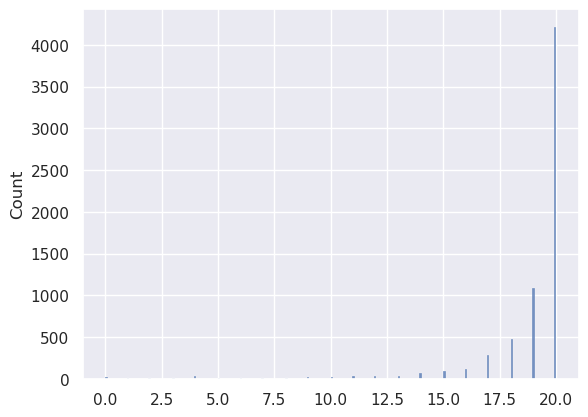

In [164]:
sns.histplot(concensus_counts)

In [165]:
concensus_counts/(ensemble_size)

array([0.85, 0.85, 1.  , ..., 0.95, 0.85, 0.85])

In [166]:
A_results = A_umap_coo.copy()
A_results.data = concensus_counts/ensemble_size
G_final = ig.Graph.Weighted_Adjacency(A_results)
final_clusters = la.find_partition(G_final, la.ModularityVertexPartition).membership

# Evaluate final clusters

In [156]:
labels = final_clusters
ari = adjusted_rand_score(targets, labels)
ami = adjusted_mutual_info_score(targets, labels)
print(f'ARI = {ari} and AMI = {ami}') 

ARI = 0.7616120438680382 and AMI = 0.8839856836496697


# Compare against UMAP+HDBSCAN

In [167]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
ari_baseline = adjusted_rand_score(targets, hd_umap_labels)
ami_baseline = adjusted_mutual_info_score(targets, hd_umap_labels)
print(f'ARI = {ari_baseline} and AMI = {ami_baseline}') 

/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


ARI = 0.7910813366998825 and AMI = 0.9424028955749346
